In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
from sklearn.datasets import load_boston

from sklearn.tree import plot_tree, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# Load data

In [3]:
data = load_boston()

In [4]:
X = data['data']
y = data['target']

In [5]:
data['feature_names']

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

# Train: Decision Tree

In [109]:
model_dt = DecisionTreeRegressor(max_leaf_nodes=10, random_state=42)
model_dt.fit(X_train, y_train)

pred_dt = model_dt.predict(X_test)
print(mean_absolute_error(y_test, pred_dt))
print(r2_score(y_test, pred_dt))

2.8483319418325292
0.813134366573089


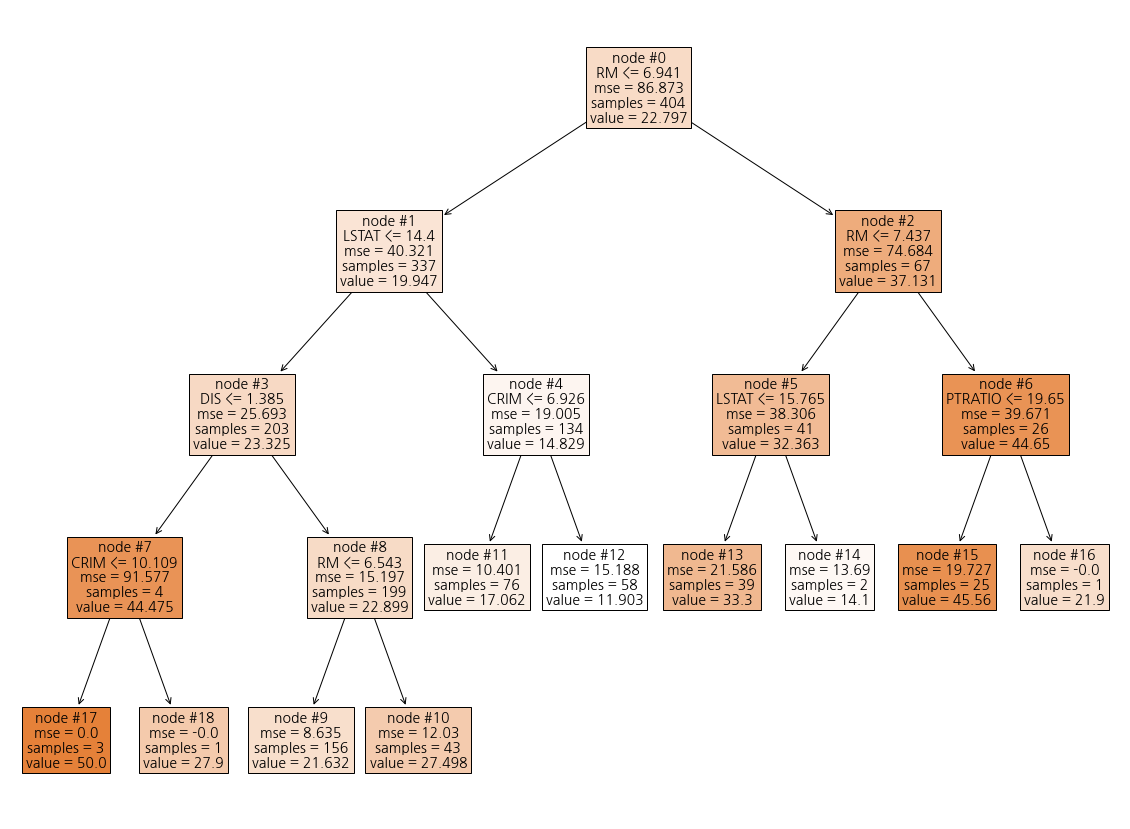

In [110]:
plt.figure(figsize=(20,15))
plot_tree(model_dt, node_ids=True, fontsize=14, feature_names=data['feature_names'], filled=True)
plt.show()

* **decision_path**: Return decision path of each sample as matrix form. If the $j$-th component of the $i$-th row is one, the $i$-th sample goes through the $j$-th node when it's being predicted.

* **apply**: Return the index of the leaf node that each sample is predicted as. If the value of the $i$-th component of the output array is $j$, the $i$-th sample stopped at $j$-th node.

In [26]:
dp = model_dt.decision_path(X_train).toarray()
apply = []
for row in dp:
    final_idx = np.where(row==1)[0][-1]
    apply.append(final_idx)

* The index of the last non-zero component in the $i$-th sample equals to the $i$-th component of the apply method's returns.

In [28]:
np.alltrue(np.array(apply)== model_dt.apply(X_train))

True

In [126]:
unique_values, unique_counts = np.unique(model_dt.apply(X_train), return_counts=True)

In [127]:
sum(unique_counts) == X_train.shape[0]

True

* Each leaf node has the unique decision path i.e. each decision path and leaf node is one-to-one corresponding.

In [115]:
n_nodes = model_dt.tree_.node_count
c2p = parent(model_dt)
dic_path = dict()
for n in range(n_nodes):
    array = np.zeros(n_nodes)
    array[0] = 1
    c = n
    while c != 0:
        array[c] = 1
        c = c2p[c]
    dic_path[n] = array

In [122]:
dpath = np.array([]).reshape(-1, n_nodes)
for row in range(X_train.shape[0]):
    dpath = np.vstack((dpath, dic_path[apply[row]]))

In [125]:
np.alltrue(model_dt.decision_path(X_train).toarray() == dpath)

True

## feature importance with sklearn instance

In [17]:
model_dt.feature_importances_

array([0.04111524, 0.        , 0.        , 0.        , 0.        ,
       0.66447956, 0.        , 0.06044371, 0.        , 0.        ,
       0.01782413, 0.        , 0.21613737])

## feature importance with my codes

$\large \displaystyle \Delta I = \frac{n_t}{n} \left( I_t - \frac{n_{tl}}{n_t} I_{tl} - \frac{n_{tr}}{n_t} I_{tr} \right)$

$n$: the number of all samples

$n_t$: the number of samples at the current node

$n_{tl}$: the number of samples at the left child node

$n_{tr}$: the number of samples at the right child node

$I_{t}$: impurity at the current node

$I_{tl}$: impurity at the left child node

$I_{tr}$: impurity at the right child node

In [18]:
n = model_dt.tree_.weighted_n_node_samples[0]
fi = np.zeros(model_dt.tree_.n_features)

for idx, feat in enumerate(model_dt.tree_.feature):
    if feat<0:
        continue
    nt = model_dt.tree_.weighted_n_node_samples[idx]
    ntl = model_dt.tree_.weighted_n_node_samples[model_dt.tree_.children_left[idx]]
    ntr = model_dt.tree_.weighted_n_node_samples[model_dt.tree_.children_right[idx]]
    
    I_t = model_dt.tree_.impurity[idx]
    I_tl = model_dt.tree_.impurity[model_dt.tree_.children_left[idx]]
    I_tr = model_dt.tree_.impurity[model_dt.tree_.children_right[idx]]
    fi[feat] += (nt / n) * ( I_t - (ntl / nt) * I_tl - (ntr / nt)* I_tr )

fi_norm = fi/fi.sum()

In [26]:
print('Is the result of running with my code the same as the result of running with scikit-learn?\n{}'.format(np.allclose(fi_norm, model_dt.feature_importances_)))

Is the result of running with my code the same as the result of running with scikit-learn?
True


# Train: Random Forest

In [20]:
model_rf = RandomForestRegressor(bootstrap=True,random_state=42)
model_rf.fit(X_train, y_train)

pred_rf = model_rf.predict(X_test)
print(mean_absolute_error(y_test, pred_rf))
print(r2_score(y_test, pred_rf))

2.0395392156862746
0.8922527442109116


## feature importance with sklearn instance

In [21]:
model_rf.feature_importances_

array([0.03806177, 0.00175615, 0.00795268, 0.00100426, 0.01554377,
       0.50384493, 0.01383994, 0.06054907, 0.00381091, 0.01566064,
       0.01631341, 0.01215362, 0.30950883])

## feature importance with my codes

In [22]:
fi_rf = np.zeros(model_rf.n_features_)
N = 0

for estimator in model_rf.estimators_:
    tree = estimator.tree_
    fi_rf_estimator = np.zeros(tree.n_features)
    n = tree.weighted_n_node_samples[0]
    #N +=n

    for idx, feat in enumerate(tree.feature):
        if feat<0:
            continue
        nt = tree.weighted_n_node_samples[idx]
        ntl = tree.weighted_n_node_samples[tree.children_left[idx]]
        ntr = tree.weighted_n_node_samples[tree.children_right[idx]]

        I_t = tree.impurity[idx]
        I_tl = tree.impurity[tree.children_left[idx]]
        I_tr = tree.impurity[tree.children_right[idx]]
        fi_rf_estimator[feat] += (nt / n) * ( I_t - (ntl / nt) * I_tl - (ntr / nt)* I_tr )  
        
    fi_rf_estimator_norm = fi_rf_estimator/fi_rf_estimator.sum()
    
    fi_rf += fi_rf_estimator_norm

In [27]:
print('Is the result of running with my code the same as the result of running with scikit-learn?\n{}'.format(np.allclose(model_rf.feature_importances_, fi_rf/model_rf.n_estimators)))

Is the result of running with my code the same as the result of running with scikit-learn?
True
